Refer to https://developers.google.com/maps/documentation/solar for guides on how to request data from Solar API

In [1]:
import requests
import os
import json
from rasterio.io import MemoryFile
import rasterio

# Look-up this address 840 Penn Avenue Northeast Atlanta,GA
# with coordinates -84.37886, 33.77764

api_key = 'YOUR_API_KEY'

def sun_roof_request(lon, lat):
    """This code is based on the example from https://developers.google.com/maps/documentation/solar/building-insights

    Args:
        lon (float): longitude coordinate in EPSG:4326
        lat (float): latitude coordinate in EPSG:4326

    Returns:
        json: building insights json response
    """
    params = {
        'location.latitude':  lat,
        'location.longitude':  lon,
        'key': api_key
        }

    r = requests.get('https://solar.googleapis.com/v1/buildingInsights:findClosest?',params=params)

    r_json = r.json()

    return r_json

def sun_roof_request_geotiff_urls(lon, lat):
    """This code is based on the example from https://developers.google.com/maps/documentation/solar/data-layers

    Args:
        lon (float): longitude coordinate in EPSG:4326
        lat (float): latitude coordinate in EPSG:4326

    Returns:
        json: urls of geotiff data
    """
    
    params = {
        'location.latitude':  lat,
        'location.longitude':  lon,
        'key': api_key,
        'radiusMeters': '100',
        'view': 'FULL_LAYERS',
        'requiredQuality': 'HIGH',
        'pixelSizeMeters': 0.1
        }

    r = requests.get('https://solar.googleapis.com/v1/dataLayers:get?',params=params)

    r_json = r.json()

    return r_json

def sun_roof_request_geotiff(url, sunroof_geotiff_filename):
    """This code is based on the example from https://developers.google.com/maps/documentation/solar/data-layers

    Args:
        url (string): url of respective geotiff type
        sunroof_geotiff_filename (string): directory/filename to save data

    Returns:
        filename: filename of saved geotiff
    """

    if os.path.isfile(sunroof_geotiff_filename) == False:
        params = {
            'key': api_key,
            }

        r = requests.get(url,params=params)
        
        with MemoryFile() as memfile:
            memfile.write(r.content)
            with memfile.open() as dataset:
                data_array = dataset.read()

                r_image = rasterio.open(sunroof_geotiff_filename, 'w', driver='GTiff',
                                            height=data_array.shape[1], width=data_array.shape[2],
                                            count=dataset.count, dtype=str(data_array.dtype),
                                            crs=dataset.crs,
                                            transform=dataset.transform)
                
                r_image.write(data_array)
                r_image.close()

    return sunroof_geotiff_filename

In [2]:
from numpy import genfromtxt
location_arr = genfromtxt('data/location_coordinates.csv', delimiter=',')
location_arr[0,:]

array([-84.37349 ,  33.781549])

In [3]:
from shapely.geometry import Point
from pyproj import Transformer
import os
import json

results = []
results_ = []

for i in range(location_arr.shape[0]):
    location = location_arr[i,:]
    sunroof_data_filename = f'data/Solar API/sunroof_data{location[0]},{location[1]}.json'
    
    # For each location from grasshopper, request Sunroof data
    if os.path.isfile(sunroof_data_filename) == False:
        result = sun_roof_request(location[0], location[1]) 
        with open(sunroof_data_filename, 'w', encoding='utf-8') as f:
            json.dump(result, f, ensure_ascii=False, indent=4)
    else:  
        with open(sunroof_data_filename) as f:
            result = json.load(f)
    
    roof = {}
    if 'maxArrayPanelsCount' in result['solarPotential'].keys():
        roof['maxArrayPanelsCount'] = result['solarPotential']['maxArrayPanelsCount']
    else:
        roof['maxArrayPanelsCount'] = 0    
    
    if 'maxArrayAreaMeters2' in result['solarPotential'].keys():
        roof['maxArrayAreaMeters2'] = result['solarPotential']['maxArrayAreaMeters2']
    else:
        roof['maxArrayAreaMeters2'] = 0       
    
    if 'solarPanelConfigs' in result['solarPotential'].keys():
        roof['maxYearlyEnergyDcKwh'] = result['solarPotential']['solarPanelConfigs'][-1]['yearlyEnergyDcKwh']
    else:
        roof['maxYearlyEnergyDcKwh'] = 0   
        
    if 'maxSunshineHoursPerYear' in result['solarPotential'].keys():
        roof['maxSunshineHoursPerYear'] = result['solarPotential']['maxSunshineHoursPerYear']
    else:
        roof['maxSunshineHoursPerYear'] = 0 
            
    roof['areaMeters2'] = result['solarPotential']['wholeRoofStats']['areaMeters2']
    roof['groundAreaMeters2'] = result['solarPotential']['wholeRoofStats']['groundAreaMeters2']
    roof['numSegments'] = len(result['solarPotential']['roofSegmentStats'])    
    roof['longitude'] = result['center']['longitude']
    roof['latitude'] = result['center']['latitude']
    
    transformer = Transformer.from_crs("EPSG:4326", f"EPSG:26916", always_xy=True)
    
    roof['points'] = Point(transformer.transform(result['center']['longitude'], result['center']['latitude']))

    
    results_.append(result)
    results.append(roof)

In [4]:
import pandas as pd 

results_df = pd.DataFrame.from_dict(results)
results_df.head()

,maxArrayPanelsCount,maxArrayAreaMeters2,maxYearlyEnergyDcKwh,maxSunshineHoursPerYear,areaMeters2,groundAreaMeters2,numSegments,longitude,latitude,points
0,64,125.66751,35831.445,1497.0555,168.77873,159.87,2,-84.373497,33.781547,POINT (743203.7475138578 3741035.5483146193)
1,99,194.39194,49388.574,1415.6703,236.27249,228.97,2,-84.373495,33.781322,POINT (743204.549387098 3741010.651277109)
2,249,488.92517,140713.830,1550.0309,871.52110,867.98,27,-84.373099,33.781397,POINT (743241.0536325278 3741019.8512914013)
3,249,488.92517,140713.830,1550.0309,871.52110,867.98,27,-84.373099,33.781397,POINT (743241.0536325278 3741019.8512914013)
4,72,141.37595,41328.523,1533.5107,228.09540,222.49,3,-84.380310,33.781643,POINT (742572.4497352929 3741030.155112597)


In [6]:
import pandas as pd
import numpy as np

results_gh = pd.read_csv('data/location_data_GH.csv').fillna(0)
results_gh = results_gh.fillna(0)
results_gh['maxArrayAreaMeters2'] = 1.879 * 1.045 * results_gh['maxArrayPanelsCount']
results_gh['corr_factor'] = results_gh['footprinAreaMeters2'] / results_gh['groundAreaMeters2']
results_gh['corr_factor'][results_gh['corr_factor'] == np.inf] = 0
results_gh.head()

C:\Users\steara\AppData\Local\Temp\ipykernel_54268\4032380764.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  results_gh['corr_factor'][results_gh['corr_factor'] == np.inf] = 0
C:\Users\steara\AppData\Local\Temp\ipykernel_54268\403238076

,maxArrayPanelsCount,maxArrayAreaMeters2,numSegments,maxSunshineHoursPerYear,totSunshineHoursPerYear,areaMeters2,groundAreaMeters2,maxYearlyEnergyDcKwh,numTreePointsInFootprint,footprinAreaMeters2,longitude,latitude,corr_factor
0,30,58.906650,2,1130.331961,3.907800e+05,94.107083,90.322003,11007.35889,2.176857,172.726072,-84.373490,33.781549,1.912337
1,0,0.000000,1,0.000000,0.000000e+00,0.000000,0.000000,0.00000,4.343554,229.765765,-84.373481,33.781317,0.000000
2,174,341.658570,4,1450.960102,2.477700e+06,432.548627,421.811686,79310.08213,1.338616,567.003723,-84.373303,33.781408,1.344211
3,177,347.549235,2,1521.436833,3.033300e+06,416.081556,410.703971,97677.28098,0.718613,526.012952,-84.372991,33.781413,1.280759
4,96,188.501280,2,1520.638618,1.255400e+06,214.428110,208.674441,50180.67482,0.236082,237.205698,-84.380291,33.781639,1.136726


In [7]:
import geopandas as gpd

points = []
for i in range(results_gh.shape[0]):
    points.append(Point(transformer.transform(results_gh['longitude'].iloc[i], results_gh['latitude'].iloc[i])))
    
results_gh['points'] = points

distances = gpd.GeoDataFrame(geometry=results_gh.points, crs='EPSG:26916').distance(gpd.GeoDataFrame(geometry=results_df.points, crs='EPSG:26916'))
distances.head()

0     0.705589
1     1.445091
2    18.951643
3    10.159349
4     1.824433
dtype: float64

In [16]:
results_gh['distances'] = distances
results_df['distances'] = distances
results_gh['error'] = results_gh['maxYearlyEnergyDcKwh'] - results_df['maxYearlyEnergyDcKwh']
results_gh[results_df.distances < 3]

,maxArrayPanelsCount,maxArrayAreaMeters2,numSegments,maxSunshineHoursPerYear,totSunshineHoursPerYear,areaMeters2,groundAreaMeters2,maxYearlyEnergyDcKwh,numTreePointsInFootprint,footprinAreaMeters2,longitude,latitude,corr_factor,points,distances,error
0,30,58.906650,2,1130.331961,3.907800e+05,94.107083,90.322003,11007.358890,2.176857,172.726072,-84.373490,33.781549,1.912337,POINT (743204.39861558 3741035.8202017066),0.705589,-24824.086110
1,0,0.000000,1,0.000000,0.000000e+00,0.000000,0.000000,0.000000,4.343554,229.765765,-84.373481,33.781317,0.000000,POINT (743205.8885823699 3741010.1082824063),1.445091,-49388.574000
4,96,188.501280,2,1520.638618,1.255400e+06,214.428110,208.674441,50180.674820,0.236082,237.205698,-84.380291,33.781639,1.136726,POINT (742574.2300777286 3741029.7564442935),1.824433,8852.151820
5,42,82.469310,2,1316.891555,5.016908e+05,101.535919,100.172340,18273.033490,1.119569,139.339305,-84.380136,33.781637,1.390996,POINT (742588.5919277039 3741029.89985371),2.216973,3022.075490
6,76,149.230180,5,1302.270153,9.874739e+05,194.251261,187.346970,31792.455370,2.174379,328.829491,-84.379951,33.781535,1.755190,POINT (742606.0146240848 3741019.0221175095),2.451400,28238.367370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0,0.000000,1,0.000000,0.000000e+00,0.000000,0.000000,0.000000,3.760035,36.169879,-84.379291,33.775627,0.000000,POINT (742683.8210630795 3740365.2703378834),0.333224,-7720.193400
824,42,82.469310,5,1491.753962,6.431804e+05,143.258065,133.269366,20409.453710,0.212437,192.998589,-84.379110,33.774816,1.448184,POINT (742702.8757793342 3740275.7419901234),2.209392,-5107.505290
827,12,23.562660,2,1357.273665,1.778016e+05,51.907371,45.503819,5081.247385,0.204652,53.749827,-84.379329,33.776458,1.181216,POINT (742677.9557291397 3740457.354135945),1.029528,-8348.321615
828,56,109.959080,4,1389.999200,5.024247e+05,124.790799,123.437027,24900.027250,0.485362,195.730038,-84.380376,33.781272,1.585667,POINT (742567.392910946 3740988.8490114957),0.407608,7842.422250


In [23]:
from scipy import stats

res = stats.pearsonr(results_df[results_gh.maxYearlyEnergyDcKwh > 0].maxYearlyEnergyDcKwh, results_gh[results_gh.maxYearlyEnergyDcKwh > 0].maxYearlyEnergyDcKwh)
res

PearsonRResult(statistic=0.8009302527498868, pvalue=2.140442663067484e-126)

In [24]:
import pandas as pd

def get_closest_only(group):

    d = group['distances']

    row_dict = {}
    row_dict['index'] = sorted(d.items(), key=lambda item: item[1])[0][0]

    return pd.Series(row_dict)


mapped_indices = results_df.groupby(['longitude', 'latitude'], as_index=False).apply(get_closest_only)['index']
results_df.iloc[mapped_indices].head()

C:\Users\steara\AppData\Local\Temp\ipykernel_54268\3348099915.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mapped_indices = results_df.groupby(['longitude', 'latitude'], as_index=False).apply(get_closest_only)['index']


,maxArrayPanelsCount,maxArrayAreaMeters2,maxYearlyEnergyDcKwh,maxSunshineHoursPerYear,areaMeters2,groundAreaMeters2,numSegments,longitude,latitude,points,distances
803,7,13.744884,3472.5571,1391.1400,24.161808,21.24,2,-84.380750,33.776383,POINT (742546.5462051658 3740445.6535074953),23.200594
747,8,15.708439,3795.9731,1233.4529,22.938904,21.72,1,-84.380710,33.776806,POINT (742549.0489726916 3740492.654967331),3.066443
424,37,72.651530,16489.8340,1378.4977,148.778980,134.60,6,-84.380675,33.779672,POINT (742544.2510295204 3740810.653480237),3.771811
743,8,15.708439,2918.3118,1108.6138,34.569880,29.76,3,-84.380672,33.775786,POINT (742555.4543846047 3740379.6521519874),2.956829
744,20,39.271095,7808.4110,1247.3570,74.197540,69.10,5,-84.380662,33.777032,POINT (742552.8478953678 3740517.846502545),2.630768


In [25]:
from scipy import stats
res = stats.pearsonr(np.abs(results_gh[results_gh['maxArrayPanelsCount'] > 1].maxYearlyEnergyDcKwh), results_gh[results_gh['maxArrayPanelsCount'] > 1].numTreePointsInFootprint)
res

PearsonRResult(statistic=-0.3190012391046913, pvalue=1.0334179272503335e-14)

Text(0.5, 0.98, 'Max Yearly Energy DC in MWh/year')

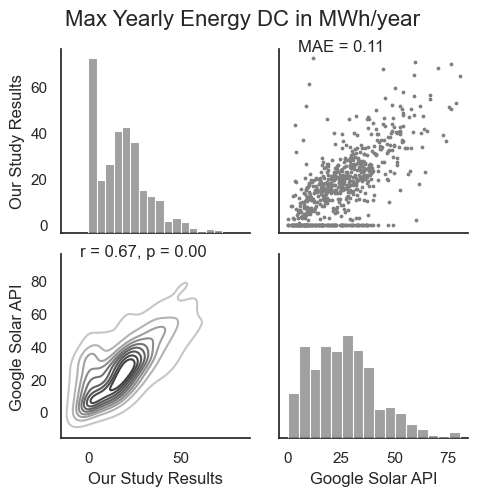

In [26]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

sns.set(style="white")

df = pd.DataFrame(data={'Our Study Results':results_gh.iloc[mapped_indices].maxYearlyEnergyDcKwh / 1000,
                        'Google Solar API':results_df.iloc[mapped_indices].maxYearlyEnergyDcKwh / 1000})

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    r =  "{:.2f}".format(r)
    p =  "{:.2f}".format(p)
    
    ax = plt.gca()
    ax.annotate("r = " + r + ", p = " + p,
                xy=(.1, .99), xycoords=ax.transAxes)
    
def rmsefunc(x, y, **kws):
    e = r2_score(x, y)
    e =  "{:.2f}".format(e)
    
    ax = plt.gca()
    ax.annotate("MAE = " + e,
                xy=(.1, .99), xycoords=ax.transAxes)
def histfunc(x, **kws):
    cm = sns.color_palette("Spectral",20)
    plot = sns.histplot(x, kde=False, bins=16, color='grey')
    
    return plot


g = sns.PairGrid(df)
g.map_upper(plt.scatter, s=3, color='grey')
g.map_upper(rmsefunc)
g.map_diag(histfunc)
g.map_lower(sns.kdeplot, cmap="Greys_d")
g.map_lower(corrfunc)
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Max Yearly Energy DC in MWh/year', fontsize=16)

Text(0.5, 0.98, 'Our Study: solar potential correlation analysis')

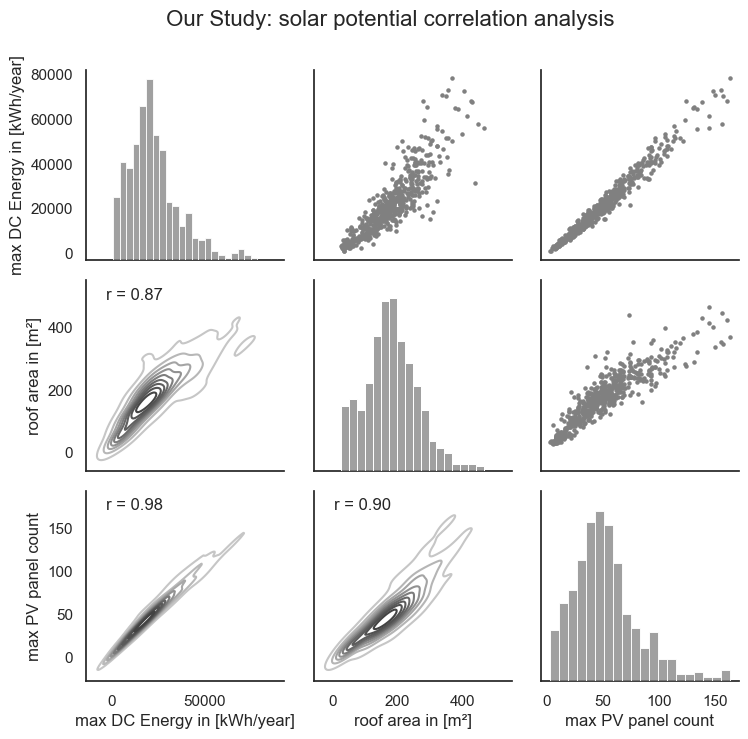

In [58]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.DataFrame(data={'max DC Energy in [kWh/year]':results_gh[results_gh.maxYearlyEnergyDcKwh > 0].maxYearlyEnergyDcKwh,
                        'roof area in [m²]':results_gh[results_gh.maxYearlyEnergyDcKwh > 0].areaMeters2,
                        'max PV panel count':results_gh[results_gh.maxYearlyEnergyDcKwh > 0].maxArrayPanelsCount})

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(df)
g.map_upper(plt.scatter, s=5, color='grey')
g.map_diag(sns.histplot, kde=False, color='grey')
g.map_lower(sns.kdeplot, cmap="Greys_d")
g.map_lower(corrfunc)
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Our Study: solar potential correlation analysis', fontsize=16)

Text(0.5, 0.98, 'Google Solar API: solar potential correlation analysis')

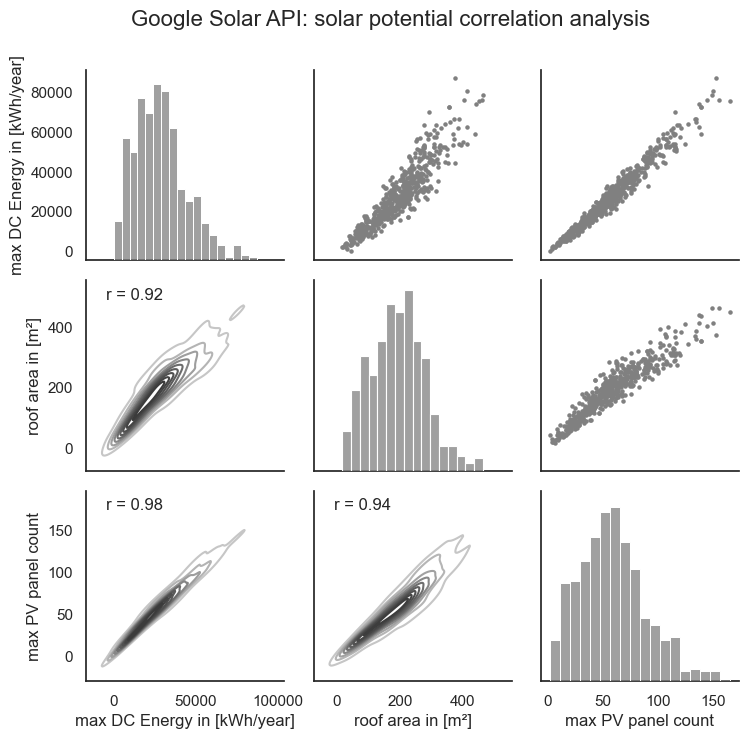

In [59]:
df = pd.DataFrame(data={'max DC Energy in [kWh/year]':results_df[results_gh.maxYearlyEnergyDcKwh > 0].maxYearlyEnergyDcKwh,
                        'roof area in [m²]':results_df[results_gh.maxYearlyEnergyDcKwh > 0].areaMeters2,
                        'max PV panel count':results_df[results_gh.maxYearlyEnergyDcKwh > 0].maxArrayPanelsCount})

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(df)
g.map_upper(plt.scatter, s=5, color='grey')
g.map_diag(sns.histplot, kde=False, color='grey')
g.map_lower(sns.kdeplot, cmap="Greys_d")
g.map_lower(corrfunc)
g.figure.subplots_adjust(top=0.9)

g.figure.suptitle('Google Solar API: solar potential correlation analysis', fontsize=16)

<Axes: >

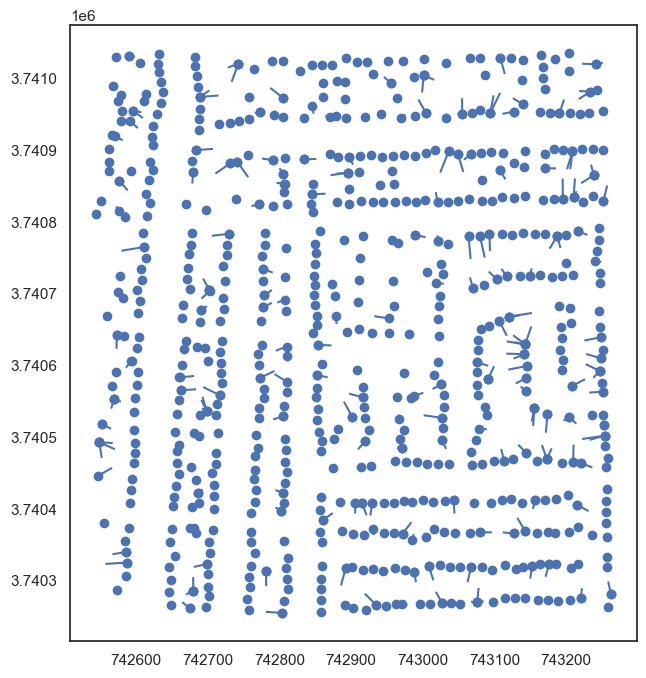

In [60]:
import geopandas as gpd
from shapely.geometry import LineString

new_pts = gpd.GeoDataFrame(geometry=results_gh.points, crs='EPSG:26916')
new_pts_ = gpd.GeoDataFrame(geometry=results_df.points, crs='EPSG:26916')

geom = []
for p1,p2 in zip(new_pts.geometry.values, new_pts_.geometry.values):
    geom.append(LineString([p1,p2]))
result= gpd.GeoDataFrame({'geometry':geom})

my_dpi = 100

fig = plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
ax = fig.add_subplot(111)

result.plot(ax=ax)
new_pts_.plot(ax=ax)

In [63]:
location = [-84.37886, 33.77764]
xmin, ymin, xmax, ymax = -84.37984, 33.77699, -84.37850, 33.77819

sunroof_data_filename = f'data/Solar API/sunroof_data{location[0]},{location[1]}.json'
sunroof_geotiff_filename = f'data/Solar API/sunroof_geotiff{location[0]},{location[1]}.json'


if os.path.isfile(sunroof_geotiff_filename) == False:
    result_geotiff = sun_roof_request_geotiff_urls(location[0], location[1]) 
    with open(sunroof_geotiff_filename, 'w', encoding='utf-8') as f:
        json.dump(result_geotiff, f, ensure_ascii=False, indent=4)
else:  
    with open(sunroof_geotiff_filename) as f:
        result_geotiff = json.load(f)

result_geotiff.keys()

dict_keys(['imageryDate', 'imageryProcessedDate', 'dsmUrl', 'rgbUrl', 'maskUrl', 'annualFluxUrl', 'monthlyFluxUrl', 'hourlyShadeUrls', 'imageryQuality'])

In [64]:
sunroof_geotiff_filename_rgb = f'data/Solar API/sunroof_geotiff_rgb{location[0]},{location[1]}.tif'
sunroof_geotiff_filename_annualFlux = f'data/Solar API/sunroof_geotiff_annualFlux{location[0]},{location[1]}.tif'
sunroof_geotiff_filename_mask = f'data/Solar API/sunroof_geotiff_mask{location[0]},{location[1]}.tif'

rgbUrl = sun_roof_request_geotiff(result_geotiff['rgbUrl'], sunroof_geotiff_filename_rgb)
annualFluxUrl = sun_roof_request_geotiff(result_geotiff['annualFluxUrl'], sunroof_geotiff_filename_annualFlux)
maskUrl = sun_roof_request_geotiff(result_geotiff['maskUrl'], sunroof_geotiff_filename_mask)

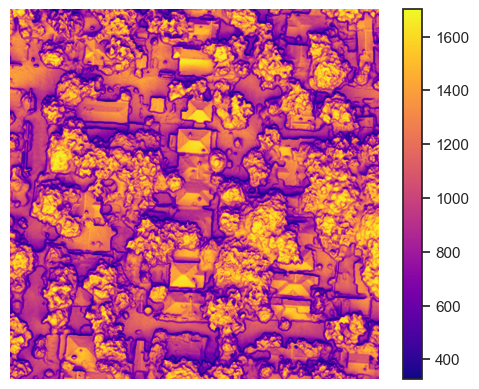

In [65]:
from rasterio.io import MemoryFile
import rasterio
from matplotlib import pyplot as plt

with rasterio.open(annualFluxUrl) as src:
    plt.imshow(src.read(1), cmap='plasma')
    plt.colorbar()
    plt.axis('off')
    plt.show()

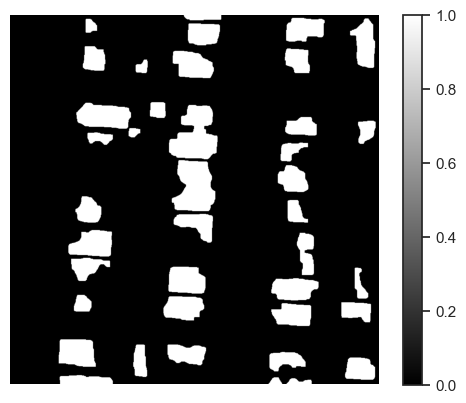

In [66]:
with rasterio.open(maskUrl) as src:
    plt.imshow(src.read(1), cmap='gray')
    plt.colorbar()
    plt.axis('off')
    plt.show()

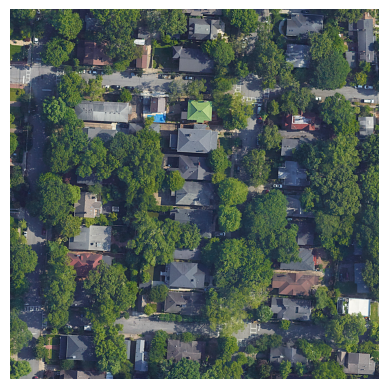

In [67]:
import numpy as np
with rasterio.open(rgbUrl) as src:
    plt.imshow(np.dstack((src.read(1), src.read(2), src.read(3))))
    plt.axis('off')
    plt.show()

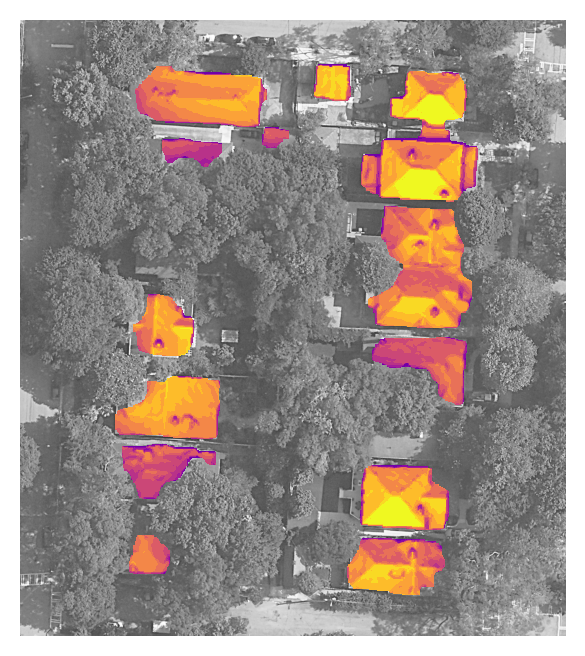

In [69]:
from rasterio.merge import merge
from rasterio.plot import show
import numpy.ma as ma
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from rasterio.windows import from_bounds
from pyproj import Transformer
import rasterio
import geopandas as gpd

annualFluxUrl_img = rasterio.open("annualFluxUrl.tif")
maskUrl_img = rasterio.open("maskUrl.tif")
rgbUrl_img = rasterio.open("rgbUrl.tif")
combined_filename = f'data/Solar API/combined{location[0]},{location[1]}.png'

target_crs = rgbUrl_img.crs.data['init']
transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
xmin_t, ymin_t = transformer.transform(xmin, ymin)
xmax_t, ymax_t = transformer.transform(xmax, ymax)

rgb_bbox = from_bounds(xmin_t, ymin_t, xmax_t, ymax_t, rgbUrl_img.transform)
mask_bbox = from_bounds(xmin_t, ymin_t, xmax_t, ymax_t, maskUrl_img.transform)
flux_bbox = from_bounds(xmin_t, ymin_t, xmax_t, ymax_t, annualFluxUrl_img.transform)


masked_annualFluxUrl_img = np.ma.masked_where(maskUrl_img.read(1, window=mask_bbox) < 1, annualFluxUrl_img.read(1, window=flux_bbox))

my_dpi = 200

fig = plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
ax = fig.add_subplot(111)

# Step 2: Create the plasma colormap instance
plasma = plt.get_cmap('plasma')
 
# Step 3: Discretize the colormap
# Define the number of bins or segments
n_bins = 15  # For example, discretize into 5 bins
colors = plasma(np.linspace(0, 1, n_bins))  # Get colors from the plasma colormap
discrete_plasma = LinearSegmentedColormap.from_list("discrete_plasma", colors, N=n_bins)

masked_annualFluxUrl_img[0,0] = 0
plt.imshow(np.mean(np.dstack((rgbUrl_img.read(1, window=rgb_bbox), rgbUrl_img.read(2, window=rgb_bbox), rgbUrl_img.read(3, window=rgb_bbox))), axis=2), cmap='Greys_r', alpha=0.80)
plt.imshow(masked_annualFluxUrl_img, cmap=discrete_plasma)
plt.axis('off')
plt.savefig(combined_filename, bbox_inches='tight')


plt.show()

annualFluxUrl_img.close()
maskUrl_img.close()
rgbUrl_img.close()

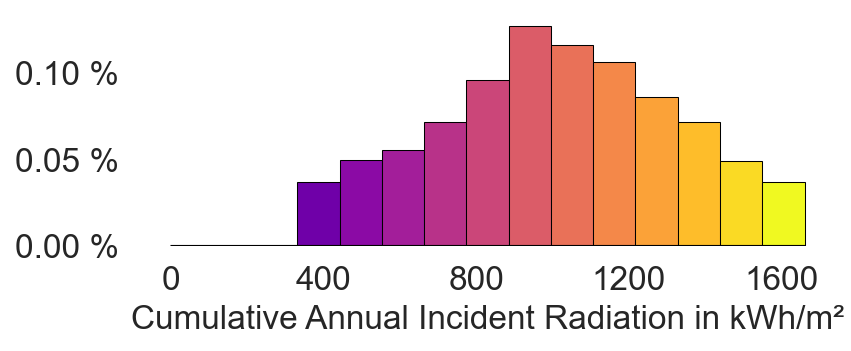

In [70]:
from matplotlib.ticker import PercentFormatter
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
sunroof_hist_filename = f'data/Solar API/sunroof_hist{location[0]},{location[1]}.png'
my_dpi = 150
plt.figure(figsize=(900/my_dpi, 300/my_dpi), dpi=my_dpi)
plt.box(False)
n, bins, patches = plt.hist(masked_annualFluxUrl_img.ravel(), bins=15, histtype='bar', density = True, color='orange', edgecolor='black', linewidth=0.5)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

font = {'fontname':'Arial', 'size'   : 16}

fmt = lambda x, pos: '{:.2f} %'.format(round(x * 100, 2))

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', plasma(c))


plt.hlines(y=0, xmin = np.min(masked_annualFluxUrl_img.ravel()), xmax=np.max(masked_annualFluxUrl_img.ravel()), colors='black')
plt.xticks(np.arange(0, 1660, step=400),  **font)
plt.yticks(**font)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
plt.xlabel("Cumulative Annual Incident Radiation in kWh/m²", **font)
plt.savefig(sunroof_hist_filename, bbox_inches='tight')
plt.show() 

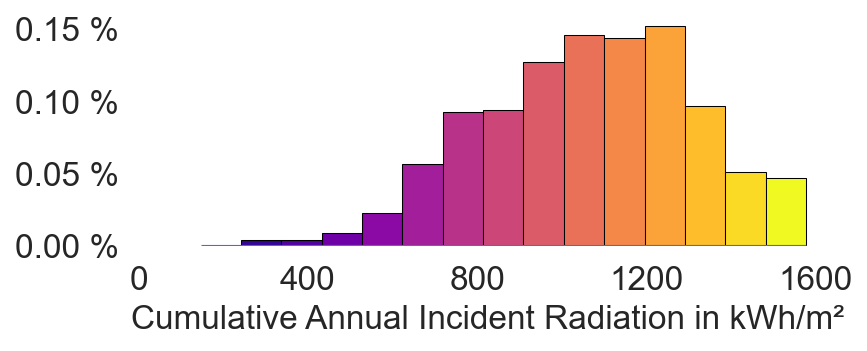

In [72]:
from matplotlib.ticker import PercentFormatter
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl

ladybug = np.loadtxt(f'data/Grasshopper/ladybug_results_osm{location[0]},{location[1]}.txt')

ladybug_hist_filename = f'data/Grasshopper/ladybug_hist_osm{location[0]},{location[1]}.png'

font = {'fontname':'Arial', 'size'   : 16}

fmt = lambda x, pos: '{:.2f} %'.format(round(x * 100, 2))

my_dpi = 150
plt.figure(figsize=(900/my_dpi, 300/my_dpi), dpi=my_dpi)
plt.box(False)
n, bins, patches = plt.hist(ladybug, bins=15, histtype='bar', density = True, color='orange', edgecolor='black', linewidth=0.5)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

plasma = plt.get_cmap('plasma')
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', plasma(c))




plt.hlines(y=0, xmin = np.min(ladybug), xmax=np.max(ladybug))
plt.xticks(np.arange(0, 1660, step=400), **font)
plt.yticks(**font)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
plt.xlabel("Cumulative Annual Incident Radiation in kWh/m²", **font)
plt.savefig(ladybug_hist_filename, bbox_inches='tight')
plt.show() 

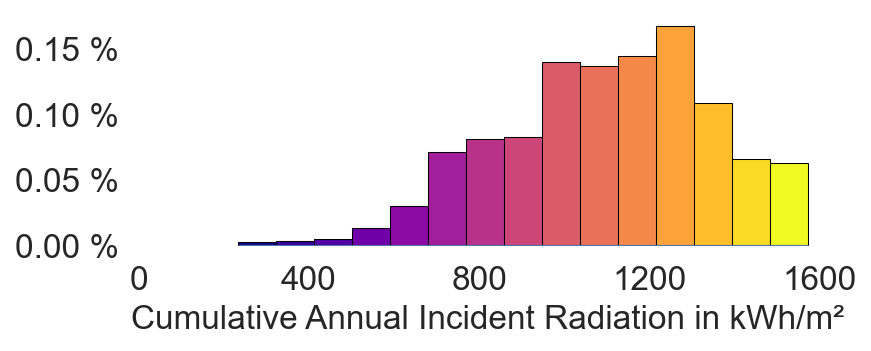

In [73]:
from matplotlib.ticker import PercentFormatter
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl

ladybug_fema = np.loadtxt(f'data/Grasshopper/ladybug_results_fema{location[0]},{location[1]}.txt')

ladybug_hist_filename = f'data/Grasshopper/ladybug_hist_fema{location[0]},{location[1]}.png'

font = {'fontname':'Arial', 'size'   : 16}

fmt = lambda x, pos: '{:.2f} %'.format(round(x * 100, 2))

my_dpi = 150
plt.figure(figsize=(900/my_dpi, 300/my_dpi), dpi=my_dpi)
plt.box(False)
n, bins, patches = plt.hist(ladybug_fema, bins=15, histtype='bar', density = True, color='orange', edgecolor='black', linewidth=0.5)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

plasma = plt.get_cmap('plasma')
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', plasma(c))




plt.hlines(y=0, xmin = np.min(ladybug_fema), xmax=np.max(ladybug_fema))
plt.xticks(np.arange(0, 1660, step=400), **font)
plt.yticks(**font)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
plt.xlabel("Cumulative Annual Incident Radiation in kWh/m²", **font)
plt.savefig(ladybug_hist_filename, bbox_inches='tight')
plt.show() 

In [74]:
from scipy.stats import wasserstein_distance

print(wasserstein_distance(ladybug, np.array(masked_annualFluxUrl_img.ravel())))
print(wasserstein_distance(ladybug_fema, np.array(masked_annualFluxUrl_img.ravel())))

77.69385104423489
101.0599467586642


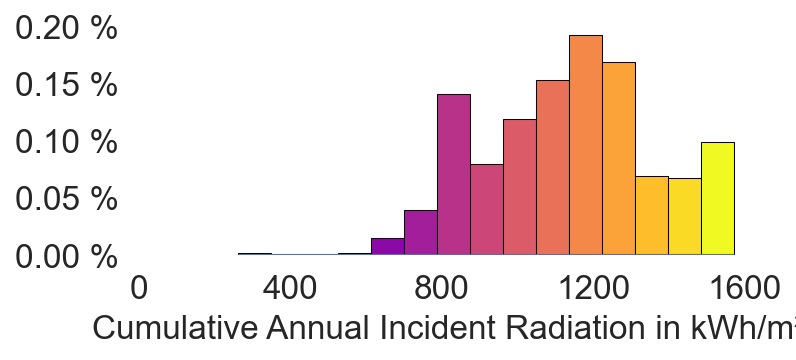

In [75]:

ladybug_panels = np.loadtxt(f'data/Grasshopper/solar_panels.txt')

ladybug_panels_filename = f'data/Grasshopper/ladybug_panels_inside_footprint{location[0]},{location[1]}.png'

my_dpi = 150
plt.figure(figsize=(800/my_dpi, 300/my_dpi), dpi=my_dpi)
plt.box(False)
n, bins, patches = plt.hist(ladybug_panels, bins=15, histtype='bar', density = True, color='orange', edgecolor='black', linewidth=0.5)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', plasma(c))


plt.hlines(y=0, xmin = np.min(ladybug_panels), xmax=np.max(ladybug_panels))
plt.xticks(np.arange(0, 1660, step=400), **font)
plt.yticks(**font)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
plt.xlabel("Cumulative Annual Incident Radiation in kWh/m²", **font)
plt.savefig(ladybug_panels_filename, bbox_inches='tight')
plt.show() 